# data from kibot -- matched with polygon where possible


In [7]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler

from madmax.api import *
from pylab import *
plt.style.use( 'seaborn-whitegrid' )
mx = mx.reload()
mxtr = mxtr.reload()

# create a configuration
mx.Config.name = 'spy_technical_20200307'
mx.Config.start()
mx.Config.hps = mx.HPSet(
    # trade during market hours     
    market_hours=True,
    # trade after market hours
    pre_market=False,
    # trade pre market hours 
    post_market=False,
)
hps = mx.Config.hps

dh(mx.Config)


Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
# load the kibot and pitrading data and compare against polygon
########################################################################
%nbagg
import json

# ETF metadata lists
bond_etfs = pd.read_excel( HOMEDIR + '/data/all-etfs.xlsx', sheet_name='bond-etfs' )
equity_etfs = pd.read_excel( HOMEDIR + '/data/all-etfs.xlsx', sheet_name='equity' )
vol_etfs = pd.read_excel( HOMEDIR + '/data/all-etfs.xlsx', sheet_name='vol' )

pidata_dir = os.path.join( HOMEDIR, 'data/pi/' )
pidata_files = OrderedDict(
    [(f.replace( '.csv', '' ), os.path.join( pidata_dir, f )) for f in os.listdir( pidata_dir ) if
     re.fullmatch( '.*csv', f )] )

kibot_day_dir = os.path.join( HOMEDIR, 'data/kibot/etf_top200_eod_adj' )
kibot_5min_dir = os.path.join( HOMEDIR, 'data/kibot/etf_top200_5min' )
kibot_day_files = OrderedDict(
    [(f.replace( '\xa0', '' ).replace( '.csv', '' ), os.path.join( kibot_day_dir, f )) for f in
     os.listdir( kibot_day_dir ) if re.fullmatch( '.*csv', f )] )
kibot_5min_files = OrderedDict(
    [(f.replace( '\xa0', '' ).replace( '.csv', '' ), os.path.join( kibot_5min_dir, f )) for f in
     os.listdir( kibot_5min_dir ) if re.fullmatch( '.*csv', f )] )

assert len( set( kibot_5min_files.keys() ).difference( kibot_day_files.keys() ) ) == len(
    set( kibot_day_files.keys() ).difference( kibot_5min_files.keys() ) ) == 0, 'ticker mismatch'


@mx.memoize
def etf_data( ticker, output='kibot_5min', verbose=True ):
    '''
    process one ticker from polygon, kibot and pitrading
    '''
    self = mx.Logger( 'etf_data', verbose=verbose )
    assert output in ['kibot_5min', 'kibot_day', 'pi'], 'bad output type'
    # get metadata for the ticker
    if ticker.startswith( 'INCOMPLETE' ):
        return None, { 'ticker': ticker }
    ticker_meta = { 'ETP Name': 'Not Found', 'Asset Class': 'Not Found' }
    for etf_list in [bond_etfs, equity_etfs, vol_etfs]:
        if ticker in etf_list.Symbol.values:
            ticker_meta = etf_list[etf_list.Symbol == ticker].iloc[0].to_dict()
            break
    ticker_meta = dict( ticker=ticker, name=ticker_meta['ETP Name'], asset_class=ticker_meta['Asset Class'] )
    with self.timer( 'Reading kibot eod data' ):
        kdf_day = pd.read_csv(
            kibot_day_files[ticker], header=None,
            names=['date', 'open', 'high', 'low', 'close', 'volume']
        ).assign( vendor='kibot_day', **ticker_meta )
        kdf_day['time'] = pd.to_datetime( kdf_day.date, format='%m/%d/%Y' ) + pd.Timedelta( 16, 'H' )
        kdf_day['dollar_volume'] = kdf_day['volume'] * kdf_day['open']
    with self.timer( 'Reading kibot 5min data' ):
        kdf_5min = pd.read_csv(
            kibot_5min_files[ticker], header=None,
            names=['date', 'timedelta', 'open', 'high', 'low', 'close', 'volume']
        ).assign( vendor='kibot_5min', **ticker_meta )
        kdf_5min['dollar_volume'] = kdf_5min['volume'] * kdf_5min['open']
        kdf_5min['time'] = pd.to_datetime( kdf_5min.date, format='%m/%d/%Y' ) + pd.to_timedelta(
            kdf_5min.timedelta + ':00' )
        # pitrading data
    if ticker in pidata_files:
        with self.timer( 'Reading pi data' ):
            pidf = pd.read_csv( pidata_files[ticker] ).assign( vendor='pi_1min', **ticker_meta )
            pidf.columns = [c.lower() for c in pidf.columns]
            pidf = pidf.rename( columns={ 'time': 'timedelta' } )
            pidf['time'] = (pd.to_datetime( pidf.date, format='%m/%d/%Y' )
                            + pd.to_timedelta(
                        pidf.timedelta.map( lambda x: '{:02}:{:02}:00'.format( x // 100, x % 100 ) ) ))
            pidf['dollar_volume'] = pidf['volume'] * pidf['open']
    else:
        pidf = None
    if output == 'kibot_5min':
        return kdf_5min, ticker_meta
    elif output == 'kibot_day':
        return kdf_day, ticker_meta
    elif output == 'pi':
        return pidf, ticker_meta
    

# to run all the ETF symbols
# etf_ops = [etf_data( ticker=ticker, output='kibot_day' ).set( verbose=True, data=chain[-1] ) for ticker in pbar( sorted( kibot_day_files ) )]
# outs = ( [op( ) for op in pbar(etf_ops) ] )
    

<IPython.core.display.Javascript object>


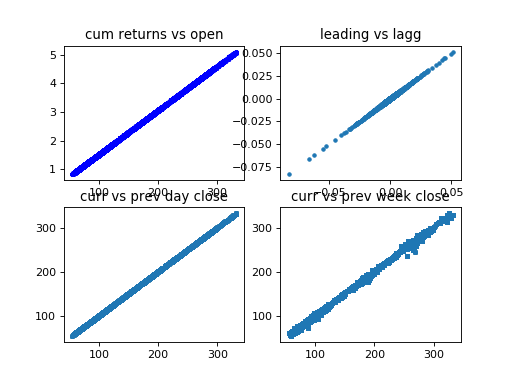

In [9]:
# --- compute returns -----
########################################################################################

@mx.memoize
def compute_returns( symbol, verbose=True ):
    logger = mx.Logger( 'compute_returns', verbose=verbose )
    
    with logger.timer( ' -- 5 min data ---' ):
        df_5min, meta_5min = etf_data( ticker=symbol )
        df_5min = df_5min.assign(
            date=df_5min.time.dt.normalize(),
            week=df_5min.time.dt.year * 10000 + df_5min.time.dt.month * 100 + df_5min.time.dt.week,
            month=df_5min.time.dt.year * 10000 + df_5min.time.dt.month * 100
        )
        df_5min = df_5min.rename(
            columns={ c: f'{c}_5min' for c in ['open', 'high', 'low', 'close', 'volume', 'dollar_volume'] } )
    with logger.timer( ' -- end of data---' ):
        df_day, meta_day = etf_data( ticker=symbol, output='kibot_day' )
        df_day = df_day.assign( date=lambda df: df.time.dt.normalize() )
        df_day = df_day.rename( columns={ c: f'{c}_day' for c in ['open', 'high', 'low', 'close'] } )
        # add in yesterday's close
        df_day = df_day.merge(
            (df_day
             .set_index( 'date' )['close_day']
             .shift( 1 )
             .reset_index()
             .rename( columns={ 'close_day': 'close_prev_day' } )),
            on='date', how='left',
        )
    with logger.timer( 'pre-market data ' ):
        # find pre-market open price
        df_pre = pd.DataFrame( {
            'open_premkt': df_5min.groupby( 'date' ).open_5min.first(),
            'high_premkt': df_5min.groupby( 'date' ).high_5min.max(),
            'low_premkt': df_5min.groupby( 'date' ).low_5min.min(),
            'close_premkt': df_5min.groupby( 'date' ).close_5min.last(),
        } ).reset_index()
    with logger.timer( ' -- weekly data --- ' ):
        week_indicator = df_day.time.dt.year * 10000 + df_day.time.dt.month * 100 + df_day.time.dt.week
        df_week = pd.DataFrame( {
            'open_week': df_day.groupby( week_indicator )['open_day'].first(),
            'high_week': df_day.groupby( week_indicator )['high_day'].max(),
            'low_week': df_day.groupby( week_indicator )['low_day'].min(),
            'close_week': df_day.groupby( week_indicator )['close_day'].last(),
        } ).reset_index().rename( columns={ 'time': 'week' } )
        df_week = df_week.merge(
            df_week.set_index( 'week' )['close_week'].shift( 1 ).reset_index().rename(
                columns={ 'close_week': 'close_prev_week' } ),
            on='week', how='left',
        )
    with logger.timer( ' -- monthly data --- ' ):
        month_indicator = df_day.time.dt.year * 10000 + df_day.time.dt.month * 100
        df_month = pd.DataFrame( {
            'open_month': df_day.groupby( month_indicator )['open_day'].first(),
            'high_month': df_day.groupby( month_indicator )['high_day'].max(),
            'low_month': df_day.groupby( month_indicator )['low_day'].min(),
            'close_month': df_day.groupby( month_indicator )['close_day'].last(),
        } ).reset_index().rename( columns={ 'time': 'month' } )
    with logger.timer( 'merging' ):
        df = df_5min
        df = df.merge( df_day.filter_mx( ['date', '/.*_day/'] ), on='date', how='left' )
        df = df.merge( df_pre, on='date', how='left' )
        df = df.merge( df_week, on='week', how='left' )
        df = df.merge( df_month, on='month', how='left' )
    # compute day-to-now and week-to-now volume and dollar volume numbers
    for ft in ['volume', 'dollar_volume']:
        df[f'{ft}_day'] = (
            df.groupby( 'date' )[f'{ft}_5min']
            .expanding().mean()
            .reset_index( level=0, drop=True )
        )
        df[f'{ft}_week'] = (
            df.groupby( 'week' )[f'{ft}_5min']
            .expanding().mean()
            .reset_index( level=0, drop=True )
        )
    # compute log volumes
    for ft in mx.Features( '/.*volume.*/' ).find( df ):
        df[f'log_{ft}'] = df[ft].log()
    with logger.timer( ' intrady and intraweek price volatility' ):
        df = df.assign( log_open_5min=df.open_5min.log() )
        df['intraday_price_vol'] = (
            df.groupby( 'date', group_keys=False )['log_open_5min']
             .expanding().std()
             .reset_index( level=0, drop=True )
        )
        df['intraweek_price_vol']  = (
            df.groupby( 'week', group_keys=False )['log_open_5min']
             .expanding().std()
             .reset_index( level=0, drop=True )             
        )
    if False:
        with logger.timer( 'plotting intervals in each session' ):
            figure()
            mkt_df = df[df.market]
            subplot( 131 )
            plot( mkt_df.groupby( mkt_df.time_index.normalize() ).count() )
            gca().set_title( 'num market intervals per day ', alpha=0.5 )
            mkt_df = df[df.pre_market]
            subplot( 132 )
            plot( mkt_df.groupby( mkt_df.time_index.normalize() ).count() )
            gca().set_title( 'num pre-market intervals per day ', alpha=0.5 )
            mkt_df = df[df.after_market]
            subplot( 133 )
            plot( mkt_df.groupby( mkt_df.time_index.normalize() ).count() )
            gca().set_title( 'num after-market intervals per day ', alpha=0.5 )
            dh( 'number of market intervals',
                df[df.market].groupby( df[df.market].time_index.normalize() )['open_5min'].count().max(), h=2 )
    with logger.timer( 'pre and post market adjustment' ):
        df = df.set_index( ['time', 'ticker'] )
        df['pre_market'] = df.time_index.time < datetime.time( 9, 30 )
        df['market'] = ((df.time_index.time >= datetime.time( 9, 30 ))
                        & (df.time_index.time < datetime.time( 16, 0 )))
        df['after_market'] = df.time_index.time >= datetime.time( 16, 0 )
        if not mx.Config.hps.post_market or mx.Config.hps.pre_market:
            df = df[df.market].drop_columns( '/.*market/' )
    with mx.timer( 'adding calendar features' ):
        df = mx.calendar_features( df )
    
    def log_rtn( da1, da2, x, y ):
        return ( np.maximum( da1.loc[:, :, x], 1e-6 ).log()
                - np.maximum( da2.loc[:, :, y], 1e-6 ).log() )
    
    with logger.timer( '# -- dataarray world ----' ):
        da = df.filter_mx( [
                  'date', '/open.*/', 'log_open_5min',
                  'close_day', 'close_week', '/close_prev_.*/',
                  '/.*_price_vol/', '/.*volume.*/', '/cos_.*/', '/sin_.*/'
              ] ).to_dataarray_mx()
        # compute various kinds of leading and lagging returns
        da = da.assign_features(
            # intraday returns
            rtn_lag_intraday=log_rtn( da, da, 'open_5min', 'open_day' ),
            # overnight returns
            rtn_lag_overnight=log_rtn( da, da, 'open_day', 'close_prev_day' ),
            # premarket returns
            rtn_lag_premarket=log_rtn( da, da, 'open_day', 'open_premkt' ),
            # returns from start of week
            rtn_lag_intraweek=log_rtn( da, da, 'open_day', 'open_week' ),
            # weekend returns
            rtn_lag_weekend=log_rtn( da, da, 'open_week', 'close_prev_week' ),
            # returns from start of month
            rtn_lag_intramonth=log_rtn( da, da, 'open_day', 'open_month' ),
            # leading return to close of day
            rtn_lead_intraday=log_rtn( da, da, 'close_day', 'open_5min' ),
            # general lagging returns
            **{ f'rtn_lag_{lag}': log_rtn( da, da.lag( lag ), 'open_5min', 'open_5min' )
                for lag in [1, '365D'] },
            # general leading returns. Note the -ve sign here
            **{ f'rtn_lead_{lead}': log_rtn( da.lag( lead ), da, 'open_5min', 'open_5min' )
                for lead in [-1, -12, -72, '-1H', '-1D'] },
        )
    # do a test here
    assert (df.index.levels[1]==[symbol]).all() and (da.ticker == symbol).all().item(), 'ticker fuckup'
    return df, da


df, da = compute_returns( symbol='SPY', verbose=True )
with mx.timer( 'sanity checking returns' ):
    figure()
    subplot( 221 )
    plot( da.loc[:, :, 'open_5min'].values.reshape( -1 ),
          da.loc[:, :, 'rtn_lag_1'].cumsum().exp().values.reshape( -1 ),
          '.b', alpha=0.3 )
    gca().set_title( 'cum returns vs open' )
    
    subplot( 222 )
    plot( da.loc[:, :, 'rtn_lag_1'].values.reshape( -1 ),
          da.loc[:, :, 'rtn_lead_-1'].shift( time=1 ).values.reshape( -1 ), '.' )
    gca().set_title( 'leading vs lagg' )
    
    subplot( 223 )
    plot( da.loc[:, :, 'close_prev_day'].values.reshape( -1 ),
          da.loc[:, :, 'close_day'].lag( '1D' ).values.reshape( -1 ), '.' )
    gca().set_title( 'curr vs prev day close' )
    
    subplot( 224 )
    plot( da.loc[:, :, 'close_prev_week'].values.reshape( -1 ),
          da.loc[:, :, 'close_week'].values.reshape( -1 ), '.' )
    gca().set_title( 'curr vs prev week close' )


In [10]:
# --- build features ---
######################################################################################################
volume_features = ['log_dollar_volume_5min', 'log_dollar_volume_day', 'log_dollar_volume_week',
                   'log_volume_5min', 'log_volume_day', 'log_volume_week']
calendar_features = ['cos_timeofday', 'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek',
                     'cos_dayofmonth', 'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear', ]
returns_features = ['rtn_lag_intraday', 'rtn_lag_overnight', 'rtn_lag_premarket',
                    'rtn_lag_intraweek', 'rtn_lag_weekend', 'rtn_lag_intramonth',
                    'rtn_lag_1', 'rtn_lag_365D']
volatility_features = ['intraday_price_vol', 'intraweek_price_vol']
returns = ['rtn_lead_-1', 'rtn_lead_-12', 'rtn_lead_-72', 'rtn_lead_-1H', 'rtn_lead_-1D', ]


@mx.memoize( verbose=True )
def build_features(
        symbol, verbose=True,
        haar=False, dilation=12, levels=4,
        zscore=False, winsorize=0.05,
        volatility_features=volatility_features, returns_features=returns_features,
        calendar_features=calendar_features, volume_features=volume_features,
):
    logger = mx.Logger( 'build_features', verbose=verbose )
    with logger.timer( 'compute_returns' ):
        df, da = compute_returns( symbol=symbol, verbose=False )
    # 1d, 10d and 30d volatility 
    with logger.timer( 'compute volatility' ):
        vol = mx.transforms.rolling( windows=np.array( [1, 10, 30] ) * 78, sid='ticker' ).sd()
        vol.features = 'log_open_5min'
        da = vol( da )
        volatility_features = volatility_features + vol.output_features
        # compute haar transform
    if haar:
        with logger.timer( 'compute haar' ):
            haar = (
                mx.transforms.haar( levels=levels, dilation=dilation, sid='ticker' )
                    .set( verbose=verbose )
            )
            da = haar( da, features=['log_dollar_volume_5min', 'rtn_lag_1'] )
            haar_features = haar.output_features
    else:
        haar_features = []
    features = volume_features + calendar_features + returns_features + volatility_features + haar_features
    # winsorize the features
    if winsorize:
        with logger.timer( 'winsorizing' ):
            wins = mx.transforms.batch( sid='ticker' ).winsorize( quantiles=winsorize )
            da = wins( da, features=features )
            # drop the original features and rename the winsorized one
            rename_map = dict( zip( wins.output_features, wins.features ) )
            da = da.drop_coords( features=features ).rename_coords( features=rename_map )
            # zscore the features
    if zscore:
        with logger.timer( 'zscoring' ):
            zscore = mx.transforms.rolling( windows=zscore, sid='ticker' ).zscore()
            da = zscore( da, features=features )
            # drop the original features and rename the zscored one
            rename_map = dict( zip( zscore.output_features, zscore.features ) )
            da = da.drop_coords( features=features ).rename_coords( features=rename_map )
            # add a dummy weight column
    da = da.assign_features( weight=da.loc[:, :, returns[0]].isfinite().astype( float ) )
    return df, da, features

if False:

    dfs = []
    das = []
    for ticker in ['SPY' , 'XLF', 'GDX', 'EEM', 'HYG', 'AGG', 'BND', 'VXX']:
        dh( 'loading data for ', ticker, h=3 )
        if ticker not in kibot_day_files.keys():
            dh( f'kibot does not have data for {ticker} = SKIPPING', h=2, color='orange' )
            continue    
        df, da, features = build_features( symbol=ticker, verbose=True )
        dfs.append( df )
        das.append( da )

    df = pd.concat( dfs, axis=0 ).sort_index( )
    da = xa.concat( das, dim='ticker' )

    reg = mx.Regression( response=None, weight=None, dk_lags=[10, 30], autocorr=None )
    with timer( 'profiling features ' ):
        res = []
        figure( figsize=(20, 30) )
        y = da.loc[:, :, 'rtn_lead_-12'].to_series().exp() - 1
        for i, f in pbar( enumerate( features ) ):
            x = daw.loc[:, :, f].to_series()
            rm = reg.apply_series( x, y )
            subplot( len( features ) + 1, 3, 3 * i + 1 )
            plot( rm['pnl'].cumsum(), '-r' )
            gca().set_title( f + ' pnl' )
            subplot( len( features ) + 1, 3, 3 * i + 2 )
            plot( x.time_index, x.rolling( 780 ).std(), '-r' )
            gca().set_title( f + ' 10D std' )
            subplot( len( features ) + 1, 3, 3 * i + 3 )
            plot( x.time_index, x.rolling( 780 ).mean(), '-r' )
            gca().set_title( f + '  10D mean' )
            rm['feature'] = f
            rm.pop( 'pnl' )
            rm.pop( 'hitRate' )
            res.append( rm )
    dh( pd.DataFrame( res ).set_index( 'feature' ) )


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core

,,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,strategy
start,end,,,,,,,,,,,,,,
1998-01-02 09:30:00,1998-12-31 15:55:00,156448,1.0,-0.028199,0.388383,0.003564,0.000013,1.409761,0.413412,0.425821,0.424036,0.425499,0.331004,0.298606,permabet
1999-01-04 09:30:00,1999-12-31 13:20:00,156656,1.0,0.476556,0.660517,0.003210,0.000010,1.270376,0.647818,0.648402,0.921095,0.915228,0.915804,0.914258,permabet
2000-01-03 09:30:00,2000-12-29 15:55:00,156624,1.0,0.199011,0.808286,0.003973,0.000016,1.572339,0.893748,0.901516,0.781767,0.769495,0.764421,0.762493,permabet
2001-01-02 09:30:00,2001-12-31 15:55:00,153768,1.0,-0.519168,0.441383,0.002737,0.000007,1.073463,0.450615,0.479876,0.834517,0.827167,0.820493,0.818238,permabet
2002-01-02 09:30:00,2002-12-31 15:55:00,156400,1.0,-0.541105,0.661264,0.004824,0.000023,1.907927,0.753858,0.750438,0.909685,0.905867,0.902779,0.900183,permabet
2003-01-02 09:30:00,2003-12-31 15:55:00,156256,1.0,0.339574,3.497342,0.019358,0.000375,7.653588,3.988925,3.690755,0.634359,0.613746,0.595629,0.592488,permabet
2004-01-02 09:30:00,2004-12-31 15:55:00,156984,1.0,0.723486,1.088123,0.006882,0.000047,2.726877,1.263748,1.235133,0.820430,0.810469,0.808263,0.803297,permabet
2005-01-03 09:30:00,2005-12-30 15:55:00,156976,1.0,0.545181,1.521037,0.008970,0.000080,3.554228,1.716930,1.683529,0.980501,0.976959,0.976999,0.976772,permabet
2006-01-03 09:30:00,2006-12-29 15:55:00,156112,1.0,0.936368,1.013984,0.006781,0.000046,2.679361,1.097761,1.019867,0.984928,0.983564,0.982236,0.981724,permabet


<IPython.core.display.Javascript object>


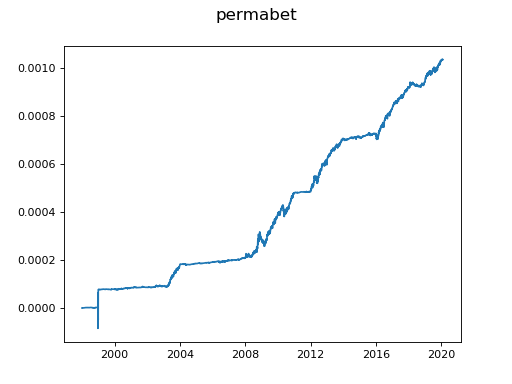

(100000, 8, 46) (100000, 8, 1) (100000, 8)


<IPython.core.display.Javascript object>


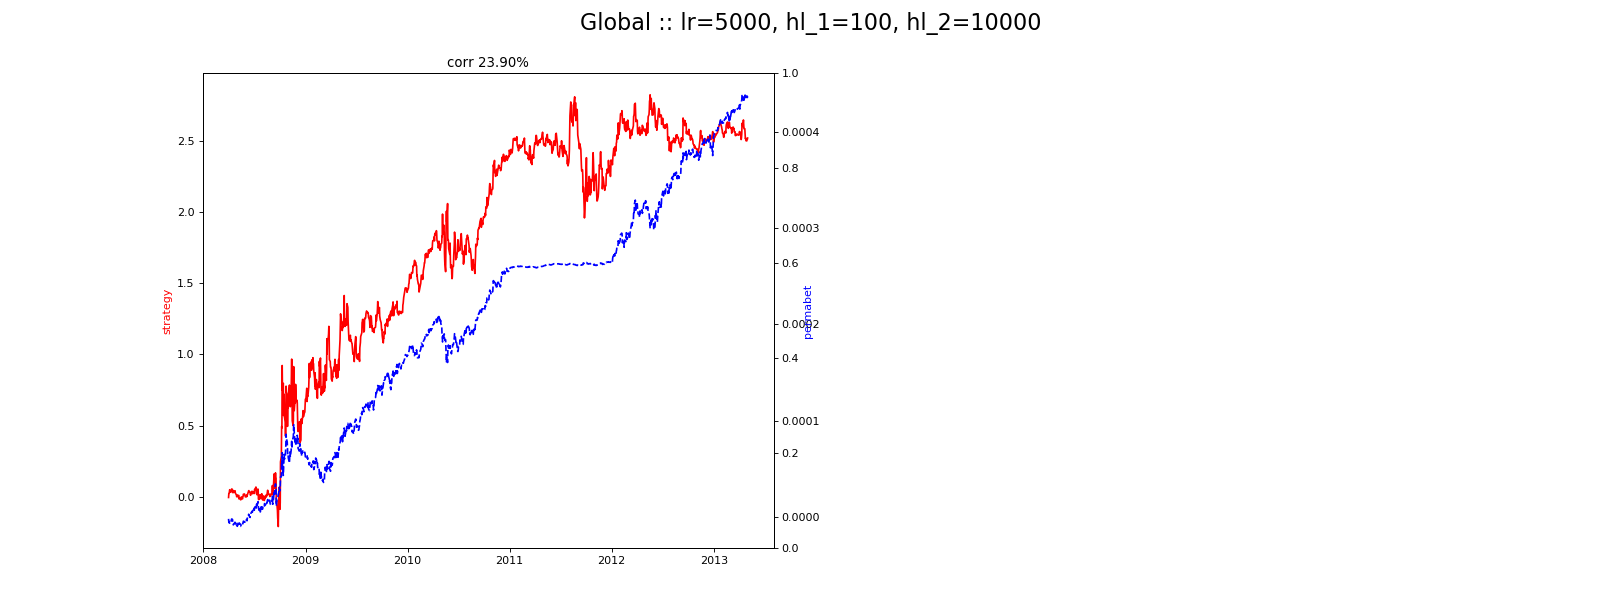

,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,strategy
intraday,799904,0.99988,-0.023359,0.600764,0.009038,0.000082,8.083895,1.623696,1.381036,0.992162,0.960342,0.778158,0.686533,intraday


(100000, 8, 46) (100000, 8, 1) (100000, 8)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

<IPython.core.display.Javascript object>


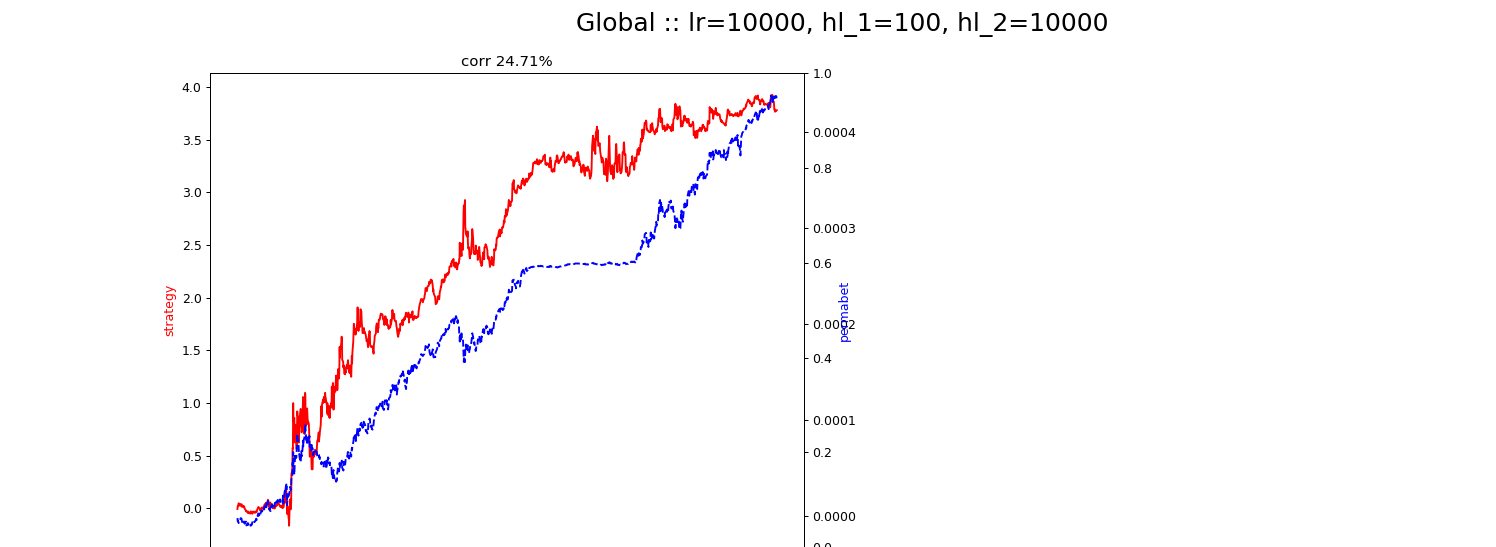

,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,strategy
intraday,799904,0.99988,-0.038815,0.913072,0.013823,0.000191,12.364073,2.462332,2.095316,0.993395,0.969195,0.807721,0.724911,intraday


(100000, 8, 46) (100000, 8, 1) (100000, 8)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

<IPython.core.display.Javascript object>


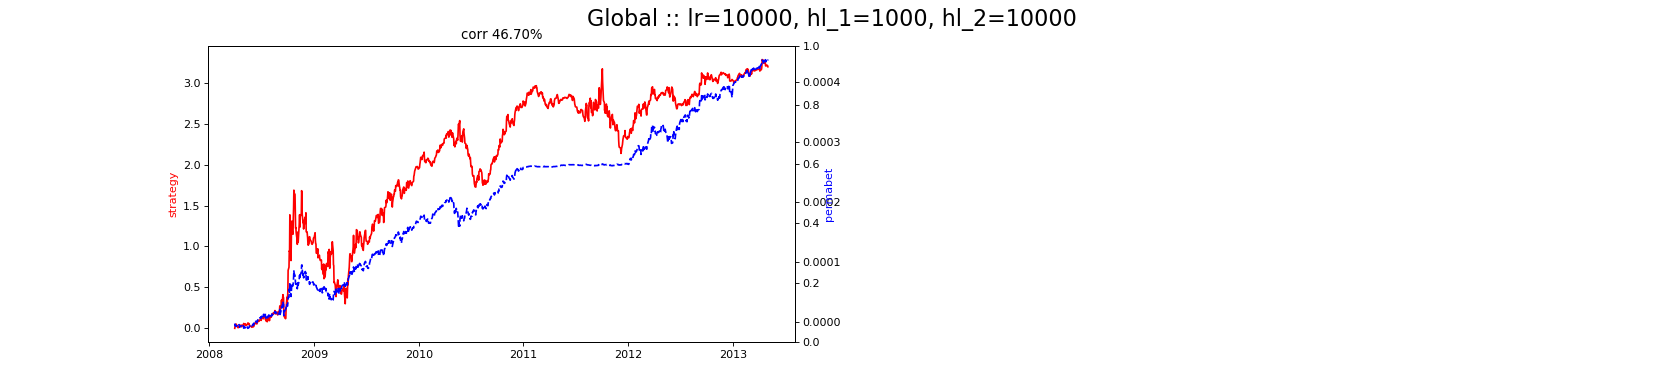

,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,strategy
intraday,799904,0.99988,-0.144297,0.771877,0.012734,0.000162,11.390158,2.186446,1.849415,0.981259,0.952306,0.91485,0.868074,intraday


In [12]:
# Multi-instrument online linear model
################################################################################################################
%nbagg

mx.Config.device = 'cuda'

mx.Config.dtype = tr.float64

reg = mx.Regression( response=returns[0], weight='one', dk_lags=[10, 30], autocorr=[1, 12, 72, 100] )

if True:
    
    dfs = []
    das = []
    for ticker in ['SPY' , 'XLF', 'GDX', 'EEM', 'HYG', 'AGG', 'BND', 'VXX']:
        dh( 'loading data for ', ticker, h=4 )
        if ticker not in kibot_day_files.keys():
            dh( f'kibot does not have data for {ticker} = SKIPPING', h=2, color='orange' )
            continue    
        df, da, features = build_features( symbol=ticker, zscore=False, haar=False, 
                                           winsorize=0.05,  verbose=True )
        dfs.append( df )
        das.append( da )

    df = pd.concat( dfs, axis=0 ).sort_index( )
    da = xa.concat( das, dim='ticker' )
    # add a dummy weight columns
    da = da.assign_features( one=da.loc[:, :, returns[0]].isfinite().astype( float ) )
    
    with mx.timer( 'permabet computation and regression'):
        permabet_regressions = []
        permabet_pnl = []
        ix = 0  
        # run a bunch of permabet regressions
        for split in mx.Freq.timesplits( da.time.to_series().min(), da.time.to_series().max(), mx.Freq.year ):
            sda = da.loc[split[0]:split[1]] 
            # compute the permabet with lookahead
            permabet_betas = (
                ( sda.loc[:,:,'one'] * sda.loc[:,:,'rtn_lead_-1'] ).mean(axis=0) 
                / ( sda.loc[:,:,'one'] * sda.loc[:,:,'rtn_lead_-1'].notnull() ).mean(axis=0)
            )
            sda = sda.assign_features( permabet=sda.loc[:,:,'one'] * permabet_betas )
            pr = reg.apply_series(
                sda.loc[:, :, 'permabet'].squeeze().to_series().fillna(0),
                sda.loc[:,:,'rtn_lead_-1'].squeeze().to_series().fillna(0)
            )
            permabet_pnl.append( pr.pop('pnl') )        
            pr.pop( 'hitRate' )
            pr['start'] = pd.to_datetime(sda.time.min().values)
            pr['end'] = pd.to_datetime(sda.time.max().values)
            pr['strategy'] = 'permabet'
            permabet_regressions.append( pr )             
        permabet_regressions = pd.DataFrame( permabet_regressions ).set_index( ['start', 'end'] )
        permabet_pnl = pd.concat( permabet_pnl )
        
    with mx.timer(' rolling window features ---'):
        xfmr = mx.transforms.rolling(
            windows=[1, 12, 30] + (np.array( [1, 2, 7, 10, 30,  ] )*78).tolist(),
            sid='ticker'
        ).mean()
        da = xfmr( da, features=['rtn_lag_1', 'log_dollar_volume_5min', 'log_open_5min', 'log_open_5min_78.rw_sd'] ) #pfeat.output_features)
    
    dh( 'Permabet ', h=2 )
    dh( permabet_regressions )
    fig = figure()
    plot( permabet_pnl.cumsum() )
    fig.suptitle( 'permabet', fontsize=15 )
        
# quadratic transformer
def quadratic_transformer( Xt ):
    '''
    compute quadratic features transforms for online learning
    '''
    Xo =  tr.einsum( 'tna,tnb->tnab', Xt, Xt )
    assert Xo.shape == (Xt.shape[0], Xt.shape[1], Xt.shape[2], Xt.shape[2] )
    return Xo.reshape( Xt.shape[0], Xt.shape[1], -1 )


for hl_1 in [100, 1000 ]:
    for lr in [5000, 10000]:    
        tr.cuda.empty_cache()
        hps.features = xfmr.output_features + [
        #     'log_dollar_volume_5min', 'log_dollar_volume_day', 'log_dollar_volume_week',
        #     'log_volume_5min', 'log_volume_day', 'log_volume_week',
              'cos_timeofday', 'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek',
              'cos_dayofmonth', 'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear',
              'rtn_lag_intraday',  'rtn_lag_intraweek',
              'rtn_lag_overnight', 'rtn_lag_premarket',
        #     'rtn_lag_weekend', 'rtn_lag_intramonth',
        #    'rtn_lag_1', 'rtn_lag_365D',
             'intraday_price_vol',   'intraweek_price_vol',
        #     'log_open_5min_78.rw_sd', 'log_open_5min_780.rw_sd',   'log_open_5min_2340.rw_sd'
        ]
        hps.returns = ['rtn_lead_-12']  
        hps.weight = 'one'
        hps.lookhead = 12
        hps.hl_1 = hl_1
        hps.hl_2 = 10000        
        hps.lr = lr
        hps.algo = 'mbprox'
        hps.loss = 'psr'
        hps.ridge = 1e-9
        hps.transformer = quadratic_transformer
        decay_1 = mx.Resolve.halflife( hps.hl_1 )['decay']
        hl_1 = mx.Resolve.halflife( hps.hl_1 )['halflife']
        decay_2 = mx.Resolve.halflife( hps.hl_2 )['decay']
        hl_2 = mx.Resolve.halflife( hps.hl_2 )['halflife']
        dh( hps )

        # assert (
        #     da_use.loc[:, :, hps.returns].notfinite().sum() 
        #     / da_use.loc[:, :, hps.returns].isfinite().sum() < 1e-3
        # ), 'too many null returns'
        da_use = da.loc[:, :, hps.features + hps.returns + [hps.weight]].fillna( 0 )[200000:300000]
        X = da_use.loc[:, :, hps.features]
        Y = da_use.loc[:, :, hps.returns]
        W = da_use.loc[:, :, hps.weight]
        print( X.shape, Y.shape, W.shape )                          

        def fit( X, Y, W ):
            '''
            one fit and regression cycle 
            '''            
            # the linear rnn learner
            linear_rnn = mxtr.LinearRNN(
                lookahead=hps.lookhead, ridge=hps.ridge, loss=hps.loss, algo=hps.algo,
                decay_1=decay_1, decay_2=decay_2, lr=hps.lr,
                transformer=hps.transformer, 
                verbose=True, 
            )        
            tr.cuda.empty_cache()
            Xt = tr.as_tensor( X.values, dtype=mx.Config.dtype, device=mx.Config.device )
            Yt = tr.as_tensor( Y.values, dtype=mx.Config.dtype, device=mx.Config.device )
            Wt = tr.as_tensor( W.values, dtype=mx.Config.dtype, device=mx.Config.device )
            Yht, meta, state = linear_rnn( Xt, Yt, Wt )
            Yh = Yht.to_dataarray( Y )
            wins = mx.transforms.batch( sid='ticker' ).winsorize( quantiles=0.05 )
            Yh = wins( Yh, features=Yh.features.values )
            return Yh.loc[:, :, wins.output_features[0]]
        
        def regress( Yh, Y, title ):
            # run a regression
            try:
                fig = figure()            
                with timer( 'running regressions' ):
                    rm = reg.apply_series( Yh.squeeze().to_series(), Y.squeeze().to_series() )
                    ax = subplot( 121 )
                    model_pnl = rm.pop( 'pnl' )
                    perma_pnl = permabet_pnl[model_pnl.index]
                    rm['strategy'] = 'intraday'
                    rm.pop( 'hitRate' )
                    ax.plot( model_pnl.cumsum(), '-r' )
                    ax.set_ylabel( 'strategy', color='red' )
                    ax.twinx().plot( perma_pnl.cumsum(), '--b' )
                    ax.twinx().set_ylabel( 'permabet', color='blue' )
                    gca().set_title( 'corr {:0.2f}%'.format( 100 * model_pnl.corr( perma_pnl ) ) )
                    gcf().show()
                    gcf().suptitle( title, fontsize=20 )
                    dh( title, h=5, color='purple' )
                    dh( pd.DataFrame( rm, index=['intraday']) )            
                return rm
            except ValueError:
                dh( title, 'regression failed ', h=3, color='red' )
                return None

        if False:
            dh( f'Fitting per-ticker models', color='blue', h=4 )
            Yhs = []
            for ticker in pbar( X.ticker.values ):
                dh( f'Fitting {ticker}', color='blue', h=5 )
                Yh = fit(  X.loc[:,[ticker], :], Y.loc[:,[ticker], :], W.loc[:,[ticker]] )            
                regress( Yh, Y.loc[:,[ticker], :], title=f'{ticker}:: lr={lr}, hl_1={hl_1}, hl_2={hl_2}' )
                # equal vol weighting when building the combined portfolio
                Yhs.append( Yh / Yh.std() * Y.loc[:,[ticker], :].std() )
            Yh = xa.concat( Yhs, dim='ticker' )    
            regress( Yh, Y, title=f'Combined:: lr={lr}, hl_1={hl_1}, hl_2={hl_2}' )            

        
        dh( f'Fitting global model', color='blue', h=4 )
        Yh = fit(  X, Y, W )
        regress( Yh, Y, title=f'Global :: lr={lr}, hl_1={hl_1}, hl_2={hl_2}' )            

In [ ]:
# test a simple online linear model for SPY only - grid search (see onenote for results)
################################################################################################################
%inline

df, da, features = build_features( 'SPY', dilation=12, levels=4, haar=False, zscore=False, winsorize=0.05, verbose=True )
# add a dummy weight columns
da = da.assign_features( one=da.loc[:, :, returns[0]].isfinite().astype( float ) )
# rolling window
xfmr = mx.transforms.rolling(
    windows=[1, 12, 30] + (np.array( [1, 2, 7, 10, 30,  ] )*78).tolist(),
    sid='ticker'
).mean()
da = xfmr( da, features=['rtn_lag_1', 'log_dollar_volume_5min', 'log_open_5min', 'log_open_5min_78.rw_sd'] ) #pfeat.output_features)

for hl_1 in [1000]: # [10, 100, 1000, 5000]:
    for lr in [1000]: #[10, 100, 1000, 5000]:        
        hps.features = xfmr.output_features + [
        #     'log_dollar_volume_5min', 'log_dollar_volume_day', 'log_dollar_volume_week',
        #     'log_volume_5min', 'log_volume_day', 'log_volume_week',
        #     'cos_timeofday', 'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek',
        #     'cos_dayofmonth', 'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear',
        #     'rtn_lag_intraday',  'rtn_lag_intraweek',
              'rtn_lag_overnight', 'rtn_lag_premarket',
        #     'rtn_lag_weekend', 'rtn_lag_intramonth',
        #    'rtn_lag_1', 'rtn_lag_365D',
             'intraday_price_vol',   'intraweek_price_vol',
        #     'log_open_5min_78.rw_sd', 'log_open_5min_780.rw_sd',   'log_open_5min_2340.rw_sd'
        ]
        hps.returns = ['rtn_lead_-12']  
        hps.weight = 'one'
        hps.lookhead = 12
        hps.hl_1 = hl_1
        hps.hl_2 = 5000
        hps.lr = lr
        hps.algo = 'mbprox'
        hps.loss = 'psr'
        hps.ridge = 1e-9
        decay_1 = mx.Resolve.halflife( hps.hl_1 )['decay']
        hl_1 = mx.Resolve.halflife( hps.hl_1 )['halflife']
        decay_2 = mx.Resolve.halflife( hps.hl_2 )['decay']
        hl_2 = mx.Resolve.halflife( hps.hl_2 )['halflife']

        reg = mx.Regression( response=hps.returns[0], weight=hps.weight, dk_lags=[10, 30], autocorr=[1, 12, 72, 100] )

        assert da.loc[:, :, hps.returns].notfinite().sum() < 20, 'too many null returns'
        da_use = da.loc[:, :, hps.features + hps.returns + [hps.weight]].fillna( 0 )[200000:300000]
        X = da_use.loc[:, :, hps.features]
        Y = da_use.loc[:, :, hps.returns]
        W = da_use.loc[:, :, hps.weight]
        print( X.shape, Y.shape, W.shape )

        def quadratic_transformer( X ):
            '''
            compute quadratic features transforms for online learning
            fs1: features to be haar transformed
            fs2: features not be be haared
            '''
            Xout = None
            return X

        mx.Config.device = 'cpu'
        mx.Config.dtype = tr.float64

        if True:
            Xt = tr.as_tensor( X.values, dtype=mx.Config.dtype, device=mx.Config.device )
            Yt = tr.as_tensor( Y.values, dtype=mx.Config.dtype, device=mx.Config.device )
            Wt = tr.as_tensor( W.values, dtype=mx.Config.dtype, device=mx.Config.device )
            with timer( 'running LinearRnn' ):
                linear_rnn = mxtr.LinearRNN(
                    lookahead=hps.lookhead, ridge=hps.ridge, loss=hps.loss, algo=hps.algo,
                    decay_1=decay_1, decay_2=decay_2, lr=hps.lr,
                    transformer=None, verbose=True
                )
                Yht, meta, state = linear_rnn( Xt, Yt, Wt )
                Yh = Yht.to_dataarray( Y )
                wins = mx.transforms.batch( sid='ticker' ).winsorize( quantiles=0.05 )
                Yh = wins( Yh, features=Yh.features.values )
                Yh = Yh.loc[:, :, wins.output_features[0]]

        with timer( 'running regressions' ):
            dh( hps )
            permabet = reg.apply_series(
                da_use.loc[:, :, 'one'].squeeze().to_series(),
                Y.squeeze().to_series()
            )
            perma_pnl = permabet.pop( 'pnl' )
            permabet.pop( 'hitRate' )
            permabet['strategy'] = 'static'
            rm = reg.apply_series( Yh.squeeze().to_series(), Y.squeeze().to_series() )
            ax = subplot( 121 )
            model_pnl = rm.pop( 'pnl' )
            rm['strategy'] = 'intraday'
            rm.pop( 'hitRate' )
            ax.plot( model_pnl.cumsum(), '-r' )
            ax.set_ylabel( 'strategy', color='red' )
            ax.twinx().plot( perma_pnl.cumsum(), '--b' )
            ax.twinx().set_ylabel( 'SPY', color='blue' )
            gca().set_title( 'corr with SPY={:0.2f}%'.format( 100 * model_pnl.corr( perma_pnl ) ) )
            gcf().show()
            dh( pd.DataFrame( [rm, permabet] ).set_index( 'strategy' ) )

        if False:
            # the online updater and linear_rnn results match quite nicely
            with timer( 'Running online-learner' ):
                lu = mx.LinearUpdater( ridge=linear_rnn.ridge, loss=linear_rnn.loss,
                                       algo=linear_rnn.algo, lr=linear_rnn.lr,
                                       hl_1=hl_1, hl_2=hl_2, )
                ol = mx.OnlineLearner(
                    updater=lu, lookahead=hps.lookhead, response=hps.returns,
                    weight=hps.weight, transformer=None
                ).set( verbose=True )
                dao = ol( da_use, features=hps.features )
                da_use = da_use.assign_features( yhat=dao )

            reg( da_use, features=ol.output_features )
            rm = reg.output_meta[0]
            plot( rm.pop( 'pnl' ).cumsum(), '--b' )
            rm.pop( 'hitRate' )
            dh( pd.Series( rm ) )
